<a href="https://colab.research.google.com/github/glee255/glee255/blob/main/Birchbox_Optimization_Model_GY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Copy-and-paste the code below to use as "set-up" when your optimization model uses Pyomo and Coin-OR solvers.
#for reference, see https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers

%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

from pyomo.environ import *
from pyomo.environ import ConcreteModel, Var, Objective, maximize

In [ ]:
#top 5 likely to buy products

df = pd.read_excel("Birchbox_data_and_excel example.xlsx", sheet_name = "item info")

prob_columns = [f'PurchaseProb_Seg_{i}' for i in range(14)]

# Convert the relevant columns to a NumPy array
probabilities = df[prob_columns].to_numpy()

# Find the indices of the top 5 probabilities vertically for each column
top_5_indices = np.argpartition(-probabilities, 4, axis=0)[:5]

# Create a list with 1 for the top 5 probabilities and 0 for all others
top_prob = np.zeros_like(probabilities, dtype=int)
top_prob[top_5_indices, np.arange(probabilities.shape[1])] = 1

top_prob1 = top_prob.T

print(len(top_prob1), len(top_prob1[0]))

14 111


In [ ]:
#inventory list
item = pd.read_excel("Birchbox_data_and_excel example.xlsx", sheet_name = "item info")
inventory = item['Inventory'].tolist()
len(inventory)

111

In [ ]:
#sample cost
sample = item['Sample Cost'].tolist()
len(sample)

111

In [ ]:
#margin
margin = item['Margin if Purchase'].tolist()
len(margin)

111

In [ ]:
#purchase probability
item = pd.read_excel("Birchbox_data_and_excel example.xlsx", sheet_name = "item info")
prob = item.iloc[:,list(range(5, 19))].values.tolist()
prob = list(map(list, zip(*prob)))
print(len(prob), len(prob[0]))

14 111


In [ ]:
#samples sent per customer
cust_df = pd.read_excel("Birchbox_data_and_excel example.xlsx", sheet_name = "cust info")
cust = cust_df.iloc[:,2:]
cust = cust.values.tolist()
len(cust[0])

111

In [ ]:
#customer seg information
cust_seg = cust_df.iloc[:,1].tolist()
len(cust_seg)

1047

In [ ]:
#optimization model
num_cust = 1047 #index seg by i
num_seg = 14 #index item by j
num_item= 111 #index item by k


#define the optimization model
model = ConcreteModel()

#DVs
model.x = Var(range(num_cust), range(num_item), domain = Binary) #which item to send to each seg customer model.x[i,k]

#define objectives
model.margin = sum(model.x[i,k] * prob[cust_seg[i]][k] * margin[k] for i in range(num_cust)  for k in range(num_item))
model.samplecost = sum(model.x[i,k] * sample[k] for i in range(num_cust)  for k in range(num_item))
model.obj = Objective(expr=(model.margin - model.samplecost), sense=maximize)


#constraint : each customer needs to be assigned to 5 items
model.assign = ConstraintList()
for i in range(num_cust):
    model.assign.add(expr=sum(model.x[i,k] for k in range(num_item)) == 5)

#constraint : each item sum needs to be within inventory
model.inventory = ConstraintList()
for k in range(num_item):
    model.inventory.add(expr=sum(model.x[i,k] for i in range(num_cust)) <= inventory[k])


#constraint : only send if they have not received the item before
model.only = ConstraintList()
for i in range(num_cust):
  for k in range(num_item):
    model.only.add(expr=model.x[i,k] + cust[i][k] <= 1)


#constraint : at least two from the top 5 likely to buy products
#model.topprob= ConstraintList()
#for i in range(num_cust):
  #model.topprob.add(expr=sum(model.x[i,k] * top_prob1[cust_seg[i]][k] for k in range(num_item)) >= 1)



In [ ]:
#solve the model
opt = SolverFactory('cbc') #cbc --> ipopt because top probability is non linear transformation.
opt.options['seconds'] = 10 #specifies the time limit (in seconds)
opt.options['ratioGap'] = .01 #specifies the optimality gap tolerance (.01 means can stop if <1% of optimal obj)
results = opt.solve(model, tee=True) #can set tee=True if you want to see the details.

Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Jun  7 2023 

command line - /content/bin/cbc -seconds 10 -ratioGap 0.01 -printingOptions all -import /tmp/tmp86fm_t7p.pyomo.lp -stat=1 -solve -solu /tmp/tmp86fm_t7p.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 10
ratioGap was changed from 0 to 0.01
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve 1158 (-116217) rows, 104370 (-11847) columns and 208740 (-139911) elements
Statistics for presolved model
Original problem has 116217 integers (116217 of which binary)
Presolved problem has 104370 integers (104370 of which binary)
==== 0 zero objective 1533 different
==== absolute objective values 1533 different
==== for integers 0 zero objective 1533 different
==== for integers absolute objective values 1533 different
===== end objective counts


Problem has 11

In [ ]:
#print the results

print("total margin: ", model.obj())
item_sending_solution = [[model.x[i,k]() for k in range(num_item)] for i in range(num_cust)]
print("which item to send to each seg customer n:", item_sending_solution)


total margin:  17275.61363177982
which item to send to each seg customer n: [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
#item sending solution to csv
result = pd.DataFrame(item_sending_solution)
result.to_csv('item_sending_solution.csv')

In [ ]:
#top 5 likely to buy probabilities and corresponding items and categories to csv


df = pd.read_excel("Birchbox_data_and_excel example.xlsx", sheet_name = "item info")


# Assuming your data is stored in a pandas DataFrame called 'df'
# Extract the columns representing purchase probabilities
prob_columns = [f'PurchaseProb_Seg_{i}' for i in range(14)]

# Convert the relevant columns to a NumPy array
probabilities = df[prob_columns].to_numpy()

# Find the indices of the top 5 probabilities vertically for each column
top_5_indices = np.argpartition(-probabilities, 4, axis=0)[:5]

# Create dictionaries to store top 5 values and indices for each segment
top_5_values_dict = {}
top_5_indices_dict = {}

# Store the results in dictionaries
for i, col in enumerate(prob_columns):
    top_5_values_dict[col] = -np.partition(-probabilities[:, i], 4)[:5]
    top_5_indices_dict[col] = top_5_indices[:, i]

# Create DataFrames from dictionaries
top_5_values_df = pd.DataFrame(top_5_values_dict)
top_5_indices_df = pd.DataFrame(top_5_indices_dict)

# Concatenate the DataFrames horizontally
result_df = pd.concat([top_5_values_df, top_5_indices_df], axis=1)

# Display the resulting DataFrame
result_df.to_csv('top 5 likely to buy.csv')

In [ ]:
# data for top 5 probabilities analysis visualization


df = result_df.iloc[:, 0:14].transpose()
df = pd.DataFrame(df)
df.rename(columns={0: 'Prob1', 1: 'Prob2', 2: 'Prob3', 3: 'Prob4', 4: 'Prob5'}, inplace=True)
df = df.rename(index={
    'PurchaseProb_Seg_0': 'Seg0',
    'PurchaseProb_Seg_1': 'Seg1',
    'PurchaseProb_Seg_2': 'Seg2',
    'PurchaseProb_Seg_3': 'Seg3',
    'PurchaseProb_Seg_4': 'Seg4',
    'PurchaseProb_Seg_5': 'Seg5',
    'PurchaseProb_Seg_6': 'Seg6',
    'PurchaseProb_Seg_7': 'Seg7',
    'PurchaseProb_Seg_8': 'Seg8',
    'PurchaseProb_Seg_9': 'Seg9',
    'PurchaseProb_Seg_10': 'Seg10',
    'PurchaseProb_Seg_11': 'Seg11',
    'PurchaseProb_Seg_12': 'Seg12',
    'PurchaseProb_Seg_13': 'Seg13'
})

df

,Prob1,Prob2,Prob3,Prob4,Prob5
Seg0,0.294609,0.296148,0.287050,0.288539,0.285685
Seg1,0.248836,0.249508,0.248534,0.252421,0.243960
Seg2,0.369648,0.378731,0.371332,0.364096,0.248534
Seg3,0.290471,0.300555,0.293912,0.292563,0.288539
Seg4,0.576657,0.577078,0.572789,0.568939,0.251749
Seg5,0.288539,0.284744,0.283920,0.278555,0.205559
Seg6,0.577078,0.571806,0.569424,0.568030,0.249548
Seg7,0.192359,0.195425,0.193075,0.190330,0.183832
Seg8,0.287522,0.288539,0.283889,0.281487,0.205559
Seg9,0.209466,0.207645,0.209969,0.205559,0.147708


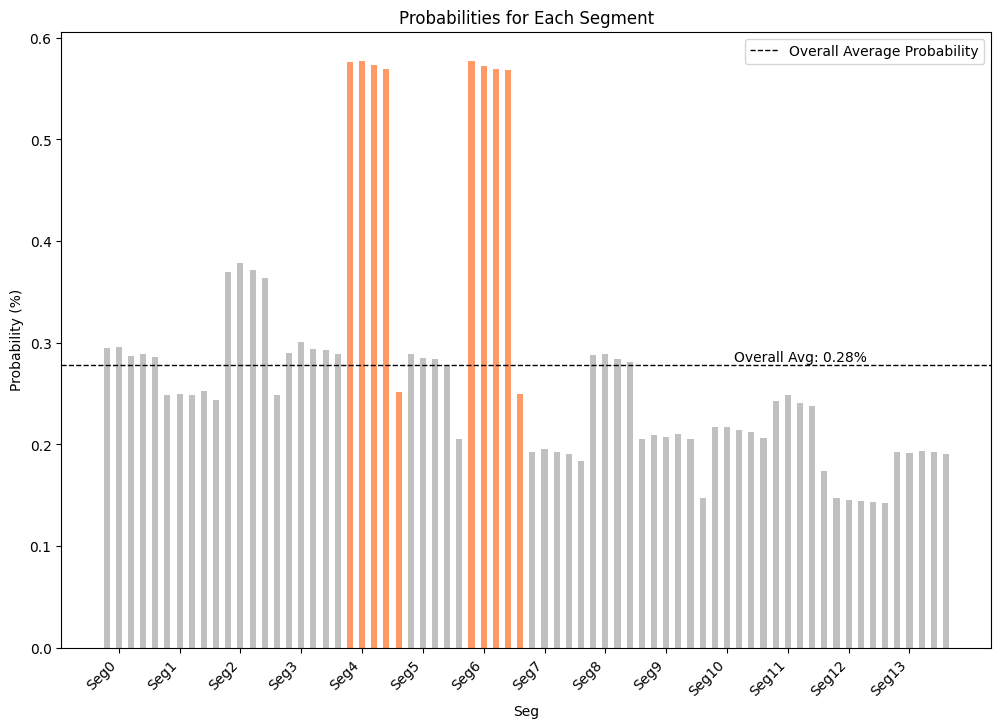

In [ ]:
# top 5 probabilities per each 13 segment

overall_average = df[['Prob1', 'Prob2', 'Prob3', 'Prob4', 'Prob5']].mean().mean()

# grey tone colors
grey_colors = ['#C0C0C0']

# Highlight color for Seg 4 and Seg 6
highlight_color = '#FF9966'  # Peach color

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

bar_width = 0.1  # Adjust bar width to add space between segments
space_width = 0.1  # Adjust space width between segments
bar_positions = range(len(df.index))

# Create a mask for Seg 4 and Seg 6
highlight_mask = (df.index == 'Seg4') | (df.index == 'Seg6')

# Plot bars for each probability column with different shades of peach color
for i, col in enumerate(['Prob1', 'Prob2', 'Prob3', 'Prob4', 'Prob5']):
    colors = [highlight_color if highlight_mask[j] and df[col][j] in df[col].nlargest(5).values else grey_colors[i % len(grey_colors)] for j in range(len(df))]
    ax.bar([pos + i * (bar_width + space_width) for pos in bar_positions], df[col], bar_width, color=colors)  # Use modulo to cycle through colors

# Plot a single horizontal line for the overall average probability
ax.axhline(y=overall_average, color='black', linestyle='--', linewidth=1, label='Overall Average Probability')

# Annotate the plot with the overall average probability on the right side
ax.text(len(df.index) - 1.5, overall_average, f'Overall Avg: {overall_average:.2f}%', ha='right', va='bottom', color='black', fontsize=10)

ax.set_xticks([pos + 2 * bar_width for pos in bar_positions])
ax.set_xticklabels(df.index, rotation=45, ha='right')
ax.set_xlabel('Seg')
ax.set_ylabel('Probability (%)')
ax.set_title('Probabilities for Each Segment')
ax.legend()

plt.show()

In [ ]:
# plot seg distribution
item_dis = pd.read_excel("Birchbox_data_and_excel example.xlsx", sheet_name = "item info")
dis = item_dis.iloc[:,0:5]
dis

,Item,Category,Inventory,Sample Cost,Margin if Purchase
0,0,6,94,7.5,51.475382
1,1,7,107,3.2,26.316932
2,2,3,119,0.8,3.772008
3,3,2,153,9.5,50.397349
4,4,7,176,1.0,5.267752
...,...,...,...,...,...
106,106,1,180,6.4,25.380000
107,107,5,237,1.7,7.700000
108,108,5,144,4.2,15.180000
109,109,2,181,1.9,8.690000


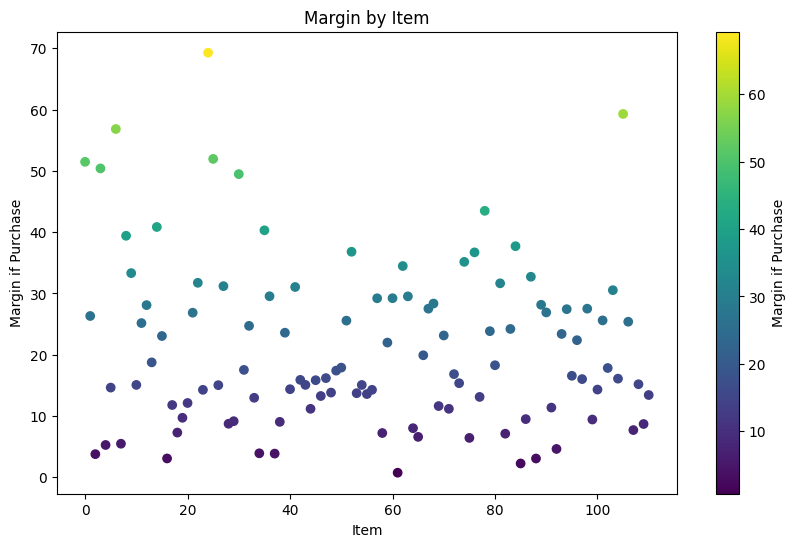

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(dis['Item'], dis['Margin if Purchase'], c=dis['Margin if Purchase'], cmap='viridis', marker='o')

# Adding labels and title
plt.xlabel('Item')
plt.ylabel('Margin if Purchase')
plt.title('Margin by Item')

# Adding colorbar
cbar = plt.colorbar()
cbar.set_label('Margin if Purchase')

# Show the plot
plt.show()

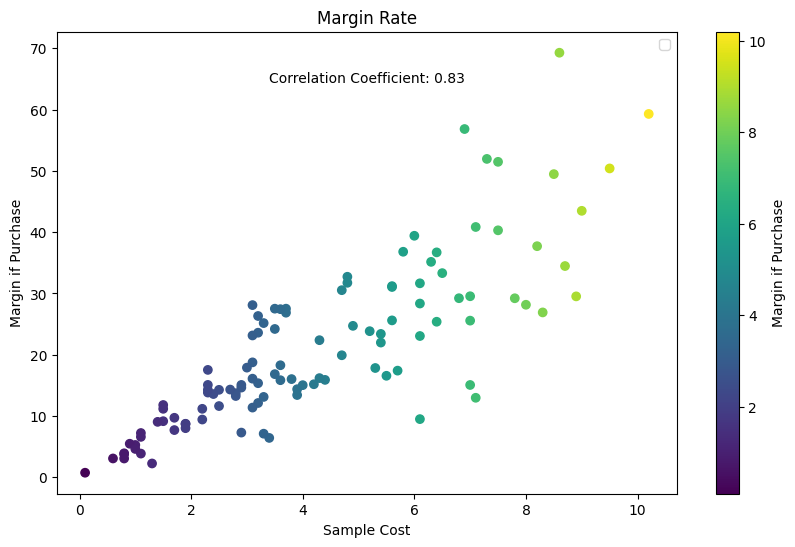

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Fit a linear regression line
coefficients = np.polyfit(dis['Sample Cost'], dis['Margin if Purchase'], 1)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(dis['Sample Cost'], dis['Margin if Purchase'], c=dis['Sample Cost'], cmap='viridis', marker='o')

# Adding labels and title
plt.xlabel('Sample Cost')
plt.ylabel('Margin if Purchase')
plt.title('Margin Rate')

# Adding colorbar
cbar = plt.colorbar()
cbar.set_label('Margin if Purchase')

# Calculate the correlation coefficient
correlation_coefficient, _ = pearsonr(dis['Sample Cost'], dis['Margin if Purchase'])

# Annotate the plot with the correlation coefficient
plt.text(0.5, 0.9, f'Correlation Coefficient: {correlation_coefficient:.2f}', ha='center', va='center', transform=plt.gca().transAxes)

# Show the legend
plt.legend()

# Show the plot
plt.show()